In [ ]:
!pip install cantera

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 17.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cantera as ct

gas = ct.Solution('gri30.yaml', transport_model=None)

equiv_ratio = .6  # lean combustion
gas.TP = 427.0, ct.one_atm
gas.set_equivalence_ratio(equiv_ratio, 'CH4:1.0', 'O2:1.0, N2:3.76')

gas.equilibrate('HP')

G_TEMP = gas.T
print(G_TEMP)

1761.5686314385262


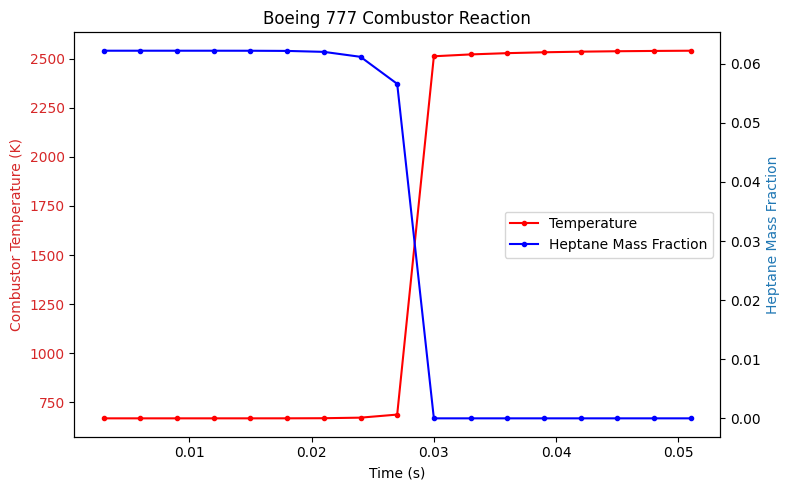

2538.6698027291145


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cantera as ct

# Create a gas object and set the base inlet conditions
gas = ct.Solution('C7H16.yaml', transport_model=None)
T_stag_inlet = 230 # K
gamma = 1.4
P_stag_inlet = 35000 # Pa
OPR = 42
BPR = 9
inlet_diameter = 135*0.0254 # m
inlet_area = np.pi*(inlet_diameter/2)**2 # m^2
Mach = 0.89 # From internet for 777 300ER
R = 287.05 # J/Kg K

# compute what I call the compressible factor
CF = 1+((gamma-1)/2)*Mach**2

# static pressure at inlet
P_static_inlet = P_stag_inlet/CF**(gamma/(gamma-1))

# static temperature at inlet
T_static_inlet = T_stag_inlet/CF

# calculate speed of sound
a = (gamma*R*T_static_inlet)**(1/2) # m/s

# velocity at Mach 0.84 in plane reference frame
v_inlet = Mach*a

# DENSITY AT INLET USING STATIC PROPERTIES
rho = P_static_inlet/(R*T_static_inlet) # density in kg/m^3

# Isentropic compression to get T and P prior to combustion
combustor_inlet_T = T_stag_inlet*(OPR)**(1-1/gamma)
gas.TP = combustor_inlet_T, OPR*P_stag_inlet

# I was messing around with unsteady
steady_equiv = 1.0

# Set the initial mixture composition with the steady equivalence ratio
gas.set_equivalence_ratio(steady_equiv, 'NC7H16:1.0', 'O2:1.0, N2:3.76')

# Create an inlet reservoir using the gas state
inlet = ct.Reservoir(gas)

# Create the combustor (a well‐stirred reactor) and the exhaust reservoir
combustor = ct.IdealGasConstPressureReactor(gas)

exhaust = ct.Reservoir(gas)

# Connect inlet to combustor and combustor to exhaust using flow controllers
mass_flow_rate = rho*v_inlet*inlet_area   # Constant mass flow rate (kg/s)

# Create flow devices
inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mass_flow_rate)
outlet_mfc = ct.PressureController(combustor, exhaust, primary=inlet_mfc, K=0.01)

# Set up the reactor network
sim = ct.ReactorNet([combustor])

# Create a SolutionArray to store states for postprocessing
states = ct.SolutionArray(gas, extra=['time', 'equiv_ratio', 'T_comb', 'Heptane_Mass'])

# Time integration parameters
t_end = .05   # Total simulation time (s)
dt = 0.003     # Time step (s)
time = 0.0

while time < t_end:
    # For a steady inlet, the equivalence ratio is constant:
    current_equiv = steady_equiv

    # Create a temporary gas state to establish the steady inlet composition
    #temp_gas = ct.Solution('C7H16.yaml', transport_model=None)
    #temp_gas.TP = base_inlet_T, ct.one_atm
    #temp_gas.set_equivalence_ratio(current_equiv, 'NC7H16:1.0', 'O2:1.0, N2:3.76')

    # Update the inlet reservoir with the new (steady) composition.
    #inlet.thermo.TPY = temp_gas.T, temp_gas.P, temp_gas.Y

    # Advance the simulation by dt seconds (the combustor state evolves continuously)
    sim.advance(time + dt)
    time = sim.time

    # Record the combustor temperature
    T_comb = combustor.thermo.T

    # Heptane mass fraction
    Y = gas.mass_fraction_dict()
    Y_heptane = Y['NC7H16']


    # Save the current state: time, constant equivalence ratio, combustor temperature
    states.append(combustor.thermo.state, time=time, equiv_ratio=current_equiv, T_comb=T_comb, Heptane_Mass=Y_heptane)

# Plot combustor temperature vs. time.
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Combustor Temperature (K)', color='tab:red')
line1, = ax1.plot(states.time, states.T_comb, 'r.-', label='Temperature')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax2 = ax1.twinx()
line2, = ax2.plot(states.time, states.Heptane_Mass, 'b.-', label='Heptane Mass Fraction')
ax2.set_ylabel('Heptane Mass Fraction', color='tab:blue')
plt.title('Combustor Reaction')

plt.legend(handles=[line1, line2], loc='center right')  # Automatically finds best position
plt.tight_layout()
plt.show()

print(states.T_comb[15])

In [ ]:
import cantera as ct

# Initialize stoichiometric heptane/air mixture at an elevated inlet temperature
gas = ct.Solution("C7H16.yaml")
gas.set_equivalence_ratio(phi=1.0, fuel={"NC7H16":1}, oxidizer={"O2":1, "N2":3.76})
gas.TP = 1020.0, 35000.0  # start at ~1020 K, 35 kPa

# Set up a constant-pressure reactor
reactor = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([reactor])

# Integrate for 0.1 s in 20 steps
times = [0.0]; temps = [reactor.T]; fuel_Y = [reactor.Y[gas.species_index("NC7H16")]]
for step in range(1, 21):
    sim.advance(step * 0.005)  # advance time
    times.append(sim.time)
    temps.append(reactor.T)
    fuel_Y.append(reactor.Y[gas.species_index("NC7H16")])

# Determine peak temperature and when fuel is fully consumed
max_temp = max(temps)
residence_time = None
for t, Y in zip(times, fuel_Y):
    if Y <= 1e-6 and residence_time is None:
        residence_time = t  # time when fuel ~0
        break

print(f"Maximum Temperature: {max_temp:.0f} K")
print(f"Residence Time (fuel consumed): {residence_time:.3f} s")


Maximum Temperature: 2532 K
Residence Time (fuel consumed): 0.085 s
